# Test image ==> croping question rerion

In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

In [2]:
import matplotlib.pyplot as plt
def show(img,figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

(2339, 1653, 3)


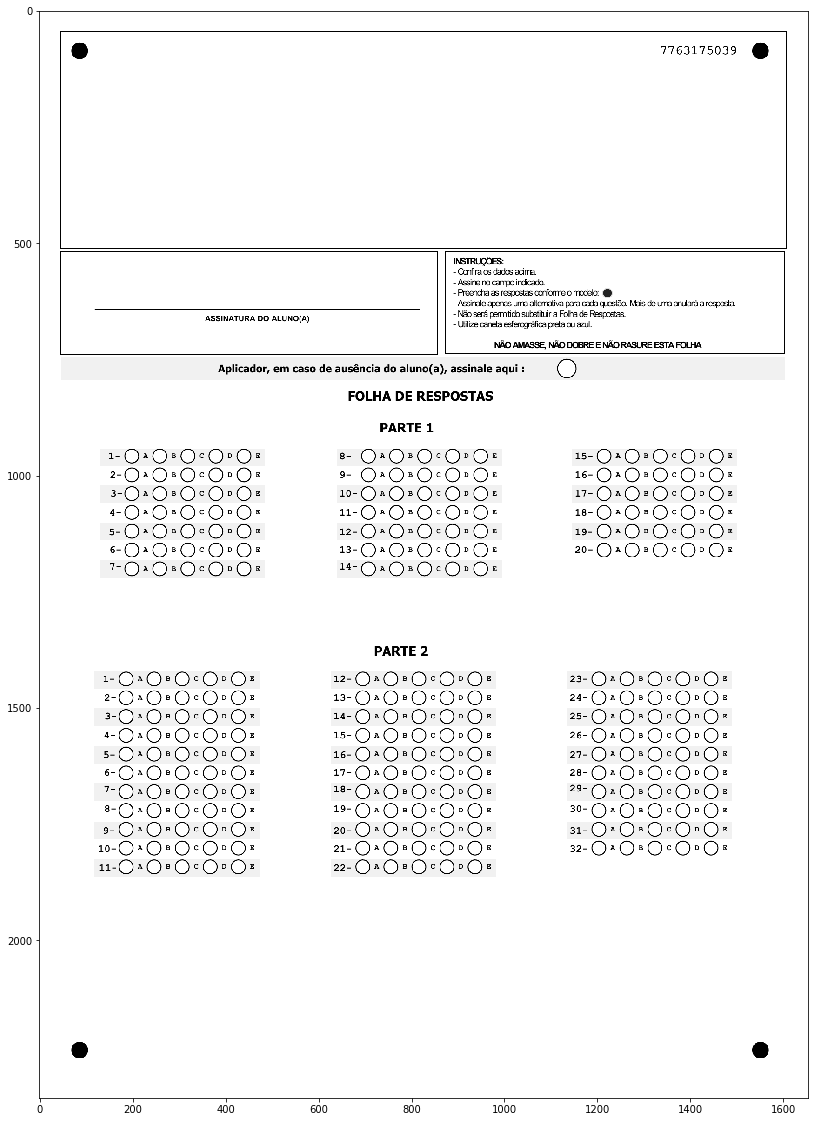

In [632]:
path = './templates/png/PT_AVALIA_20_32_AE.png'
# path = 'LOTE3/png/GABARITO 1_ELETRICISTA DE MANUTENCAO.png'

image = cv2.imread(path)
h,w,c = image.shape
print(image.shape)
show(image, (20,20))

## (blur + gamma) ajusted image

In [603]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
 
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

def blur(image, n=2):
    kernel = np.ones((n,n),np.float32)/(n**2)
    return cv2.filter2D(image.copy(),-1,kernel)
    

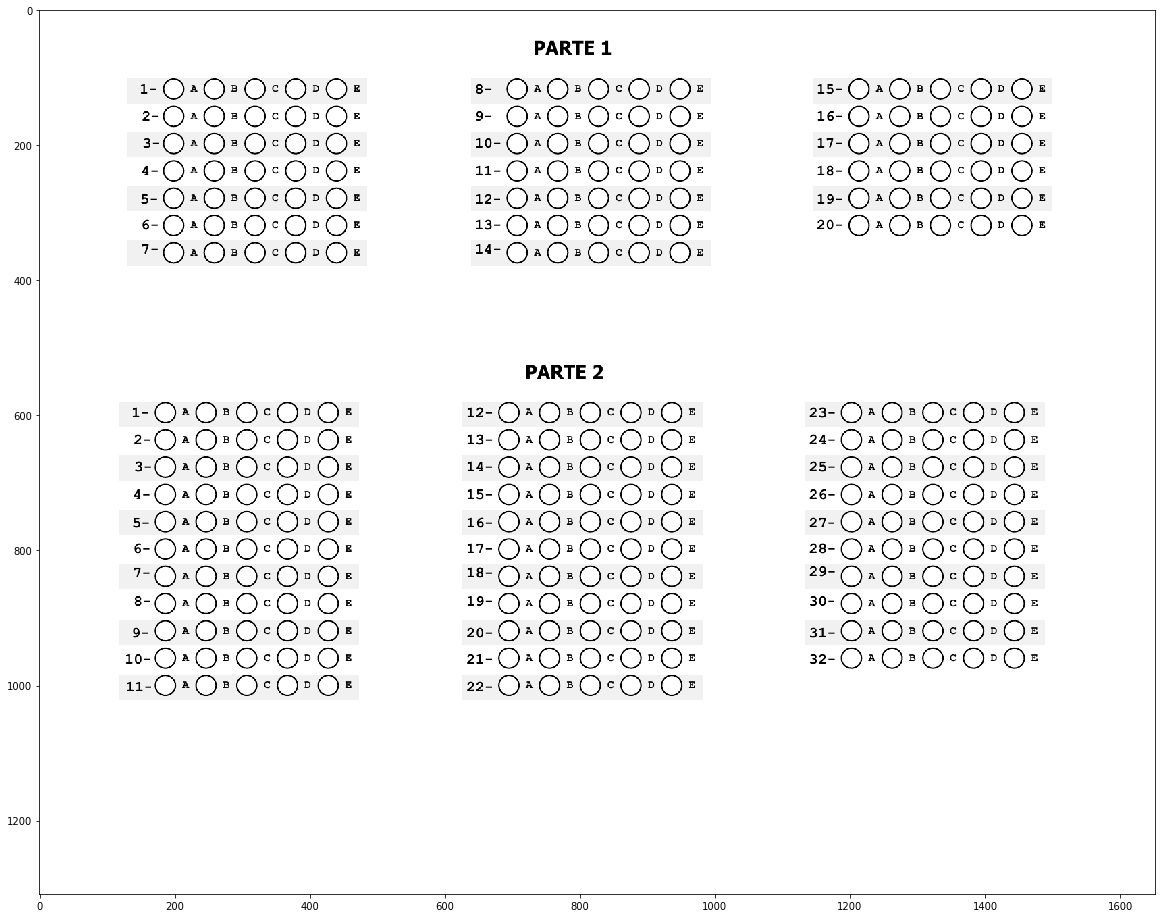

In [633]:
# adj_img = adjust_gamma(blur(image.copy()), gamma=0.2)
adj_img = image.copy()
adj_img = adj_img[int(0.36*h):int(0.92*h), 0:w]
show(adj_img,(20,20))

## Option location

In [636]:
def option_location(image, imshow=False):
    
    test = image.copy()
    
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    warped = gray.copy()

    thresh = cv2.threshold(warped, 0,127,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)

    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    ###################################################################
    # loop over the contours
    
    option_cnts = []
    for c in cnts:
        # compute the bounding box of the contour, then use the
        # bounding box to derive the aspect ratio
        (x, y, w, h) = cv2.boundingRect(c)

        _w = _h = 18.5
        
        if(w >= _w and h >= _h and np.abs(w-h)<4): 
            circles = cv2.HoughCircles(gray[y:y+h, x:x+w], 
                                       cv2.HOUGH_GRADIENT, 1,100, 
                                       param1=20,param2=10,minRadius=13,maxRadius=0)
            if circles is not None:
                for i in circles[0,:]:
                    cv2.circle(test[y:y+h, x:x+w],(i[0],i[1]),i[2],(0,255,0),2)
                    cv2.circle(test[y:y+h, x:x+w],(i[0],i[1]),2,(0,255,0),3)
                option_cnts.append(c)
        
    show(test, (20,20))
                
    ###################################################################
    # count marked ops

    # questionCnts = contours.sort_contours(questionCnts,method="left-to-right")[0]
    option_cnts = contours.sort_contours(option_cnts,method="top-to-bottom")[0]
    
    # print("Pontos identificados:",len(option_cnts))
    return option_cnts

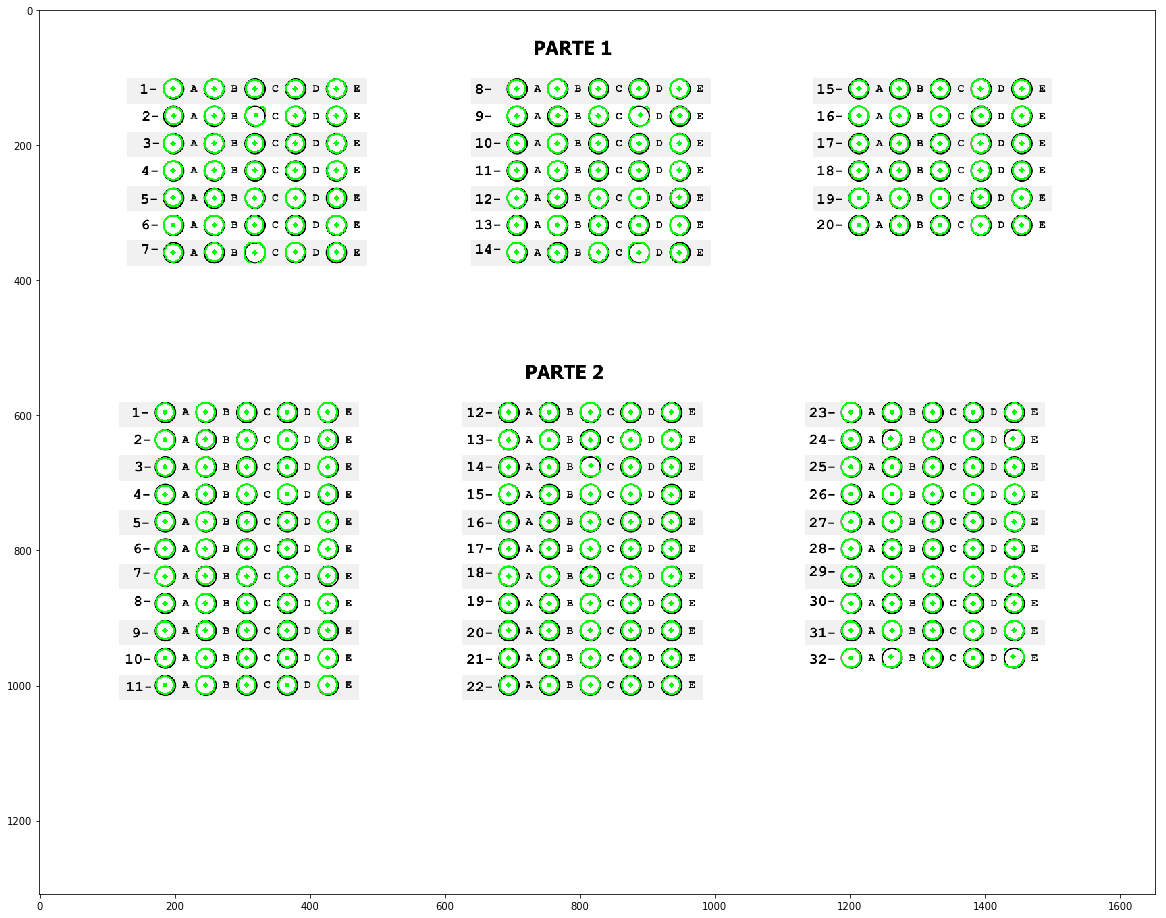

In [637]:
option_locations = option_location(adj_img)

## List of marked option for each qregion

In [629]:
def isdarker(piece, tresh=0.60):
    "this function ..."
    "cluster image colors => copare to tresh hold => return true if image is darker the tresh"
    
    from sklearn.cluster import KMeans

    image = piece.copy()
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gray scale vector
    image = image.reshape((image.shape[0] * image.shape[1], 1)) 

    clt = KMeans(n_clusters = 2)
    clt.fit(image)
    centroids =  clt.cluster_centers_

    ## Histogram

    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    (pr1, cl1), (pr2, cl2) =  zip(hist, centroids)

    if(cl1[0] < cl2[0] and pr1 >= tresh):
        return True

    if(cl2[0] < cl1[0] and pr2 >= tresh):
        return True
    else:
        return False

In [630]:
def marked_option(croped_image, option_cnts, imshow=True):
    
    croped = croped_image.copy()
        
    # sort the contours for the current question from
    # left to right, then initialize the index of the option Id
    # bubbled answer
    cnts = contours.sort_contours(option_cnts)[0]
    cnts = contours.sort_contours(cnts, method="left-to-right")[0]
    bubbled = None

    # loop over the sorted contours
    marded_opts = list()
    for (j, c) in enumerate(cnts):

        (x, y, w, h) = cv2.boundingRect(c)
        piece = croped[y:y+h, x:x+w]
        piece = cv2.fastNlMeansDenoisingColored(piece, None, 50,3)
        markerd = isdarker(piece)

        if(markerd):
            marded_opts.append(1)
            color = (0, 255, 0)           
        else:
            marded_opts.append(0)
            color = (255, 0, 0)
        

        if(imshow == True):
            cv2.drawContours(croped, [cnts[j]], -1, color, 3)
            
    if(imshow == True): show(croped, (20,20))
    return marded_opts

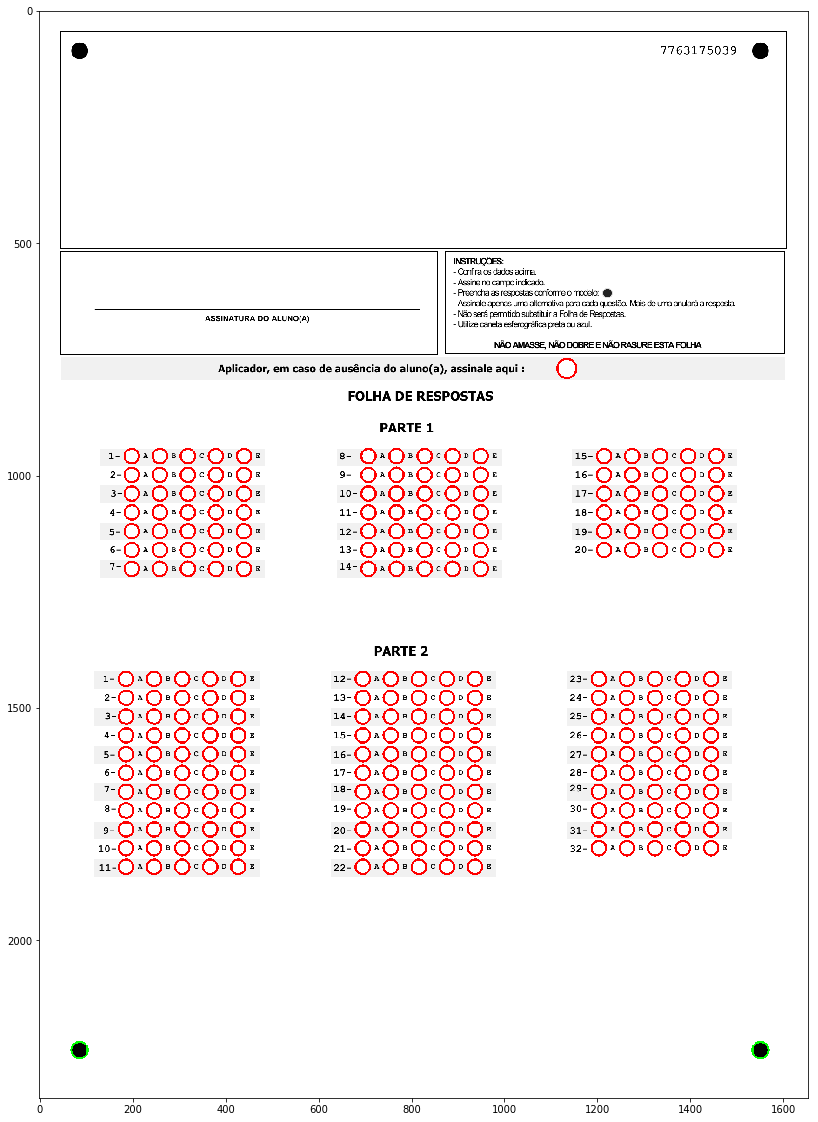

In [631]:
marked_options = marked_option(adj_img, option_locations, imshow=True)